# Mental Health Access Demo

### Folder Structure
- `data/`: inputs data files (synthetic data)
- `result/`: generated outputs (e.g., distance, estimated supply, estimated demand)
- `model/`: access model outputs
- `analysis/`: community-level visualizations

### Required Packages
numpy, pandas, scikit-learn, geopandas, ...

### Data
- public information
    - `census.csv`: census tract information, from Census Bureau
    - `provider_info.csv`: provider information from NPPES
    - `provider_geocode.csv`: provider practice locations with geocoding (latitude, longitude)
    - `tract_1318.json`: TopoJSON file with census tract boundaries (for visualization)
- claims data
    - `community.csv`: patient ID with census tract of residence
    - `diagnostic_claims.csv`: patient ID, provider NPI, service date for mental health-related diagnostic claims
    - `procedural_claims.csv`: patient ID, provider NPI, service date for mental health-related procedural claims

In [21]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import haversine_distances
from model import AccessModel
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

In [18]:
# Prepare folders
if not os.path.exists("result"):
    os.makedirs("result")
if not os.path.exists("model"):
    os.makedirs("model")
if not os.path.exists("analysis"):
    os.makedirs("analysis")
if not os.path.exists("data"):
    os.makedirs("data")

## Estimating Supply, Demand, and Travel Distance
- `supply.csv`: estimated supply per practice location
- `need.csv`: estimated need per census tract
- `distance.csv`: travel distance matrix between census tracts and practice locations, up to a threshold (e.g., 50 miles)

In [2]:
def estimate_supply():
    proceduralDF = pd.read_csv("data/procedure_claims.csv")
    taxonomyDF = pd.read_csv("data/provider_info.csv")
    providerDF = pd.read_csv("data/provider_geocode.csv")
    
    # number of caseloads per mental health provider
    proceduralDF = proceduralDF[['PATIENT_ID', 'NPI', 'SERVICE_DATE']].drop_duplicates()
    mhNPIList = taxonomyDF[taxonomyDF['TAXONOMY'] == 'MentalHealth']['NPI'].unique()
    proceduralDF = proceduralDF[proceduralDF['NPI'].isin(mhNPIList)]
    proceduralDF = pd.merge(proceduralDF, taxonomyDF, on='NPI', how='inner')
    
    # number of caseloads per practice location
    supplyDF = pd.merge(proceduralDF, providerDF, on='ADDRESS_ST', how='inner')
    supplyDF = supplyDF.groupby('PROVIDER_ID').size().reset_index(name='CASELOAD')
    
    supplyDF[['PROVIDER_ID', 'CASELOAD']].to_csv("result/supply.csv", index=False)
    print(f"Total Supply: {supplyDF['CASELOAD'].sum()}")

estimate_supply()

Total Supply: 713770


In [3]:
def estimate_demand():
    communityDF = pd.read_csv("data/community.csv")
    tractDF = pd.read_csv("data/census.csv")
    
    cohort = get_study_population() # get study population
    distribution = get_need_distribution(cohort) # get need distribution
    
    # estimate patient count per tract
    communityDF = communityDF[communityDF['PATIENT_ID'].isin(cohort)]
    patientDF = pd.merge(communityDF, tractDF, on='GEOID', how='inner')
    patientDF = patientDF.groupby('TRACT_ID').size().reset_index(name='PATIENT_COUNT')
    
    # sample for demand per tract based on need distribution
    patientDF['DEMAND'] = patientDF.apply(lambda row: np.sum(np.random.choice(distribution, size=row['PATIENT_COUNT'], replace=True)), axis=1)
    
    patientDF[['TRACT_ID', 'DEMAND']].to_csv("result/need.csv", index=False)
    print(f"Patient Count: {patientDF['PATIENT_COUNT'].sum()}, Demand: {patientDF['DEMAND'].sum()}")
    
    
def get_study_population(): # two diagnostic or one procedural
    diagnosticDF = pd.read_csv("data/diagnostic_claims.csv")
    proceduralDF = pd.read_csv("data/procedure_claims.csv")

    diagnosticDF = diagnosticDF[['PATIENT_ID', 'NPI', 'SERVICE_DATE']].drop_duplicates()
    diagnosticDF = diagnosticDF.groupby('PATIENT_ID').size().reset_index(name='COUNT')
    diagnosticDF = diagnosticDF[diagnosticDF['COUNT'] >= 2]
    proceduralDF = proceduralDF[['PATIENT_ID', 'NPI', 'SERVICE_DATE']].drop_duplicates()
    
    cohort = set(diagnosticDF['PATIENT_ID']) | set(proceduralDF['PATIENT_ID'])
    return cohort

def get_need_distribution(cohort): # adjusted empirical distribution for patient needs
    diagnosticDF = pd.read_csv("data/diagnostic_claims.csv")
    proceduralDF = pd.read_csv("data/procedure_claims.csv")
    diagnosticDF = diagnosticDF[diagnosticDF['PATIENT_ID'].isin(cohort)]
    proceduralDF = proceduralDF[proceduralDF['PATIENT_ID'].isin(cohort)]
    diagnosticDF = diagnosticDF[['PATIENT_ID', 'NPI', 'SERVICE_DATE']].drop_duplicates()
    proceduralDF = proceduralDF[['PATIENT_ID', 'NPI', 'SERVICE_DATE']].drop_duplicates()
    distributionDF = pd.concat([diagnosticDF, proceduralDF])
    distributionDF = distributionDF.groupby('PATIENT_ID').size().reset_index(name='COUNT')
    
    frequency = distributionDF['COUNT'].values
    p95 = np.percentile(frequency, 95)
    frequency[frequency > p95] = p95 # upperbound at 95th percentile
    frequency[frequency < 2] = 2 # lowerbound is 2
    avg = np.mean(frequency)
    frequency = np.ceil(frequency + (8 - avg)) # shift to average of 8, based on guidelines
    return frequency

estimate_demand()

Patient Count: 137103, Demand: 1118951.0


In [4]:
def get_distance(threshold): # estimate travel distance with Euclidean distance, capped at threshold=50 miles
    providerDF = pd.read_csv("data/provider_geocode.csv")[['PROVIDER_ID', 'LATITUDE', 'LONGITUDE']]
    censusDF = pd.read_csv("data/census.csv")[['TRACT_ID', 'LATITUDE', 'LONGITUDE']]
    providerCoord = providerDF[['LATITUDE', 'LONGITUDE']].values
    censusCoord = censusDF[['LATITUDE', 'LONGITUDE']].values
    distance = haversine_distances(np.radians(providerCoord), np.radians(censusCoord)) * 3958.8  # in miles    
    mask = distance <= threshold
    provider_idx, tract_idx = np.where(mask)
    provider_ids = providerDF['PROVIDER_ID'].to_numpy()
    tract_ids = censusDF['TRACT_ID'].to_numpy()
    selected_distance = distance[provider_idx, tract_idx]
    resultDF = pd.DataFrame(
        {
            'PROVIDER_ID': provider_ids[provider_idx],
            'TRACT_ID': tract_ids[tract_idx],
            'DISTANCE': selected_distance,
        }
    )
    resultDF[['PROVIDER_ID', 'TRACT_ID', 'DISTANCE']].to_csv("result/distance.csv", index=False)
    
get_distance(threshold=100)

## Access Model
checkout `model.py`
**Parameters**:
- $c_{ij}$: travel distance from census tract $i$ to practice location $j$
- $s_j$: caseload at practice location $j$
- $d_i$: demand at census tract $i$
- $p$: no-show rate (=10%)
- $\lambda$: trade-off between travel distance and coverage (=1e-6)
- $t$: intervention, additional $t\%$ of supply added to all practice locations

**Variables**:
- $x_{ij}$: number of needs from census tract $i$ assigned to practice location $j$

**Objective**: minimize total travel distance, $\lambda \times \sum_{i,j} x_{ij} \times c_{ij} + (1-\lambda) \times \frac{\sum_{i, j} x_{ij}}{\sum_{i} d_i}\times 100$

**Constraints**:
- Supply constraint: $\sum_{i} x_{ij} \leq s_j * (1 + p/100)$ for all $j$
- Demand constraint: $\sum_{j} x_{ij} \leq d_i$ for all $i$


In [13]:
# run single model without intervention
_ = AccessModel(intervention=0)

Loading data...
Setting up model...
Solving model...
Model is optimal; Result saved to model/result_intervention0.csv


In [24]:
INTERVENTION_LIST = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170]
def model_wrapper(intervention):
    _ = AccessModel(intervention=intervention)
_ = Parallel(n_jobs=-1)(delayed(model_wrapper)(intervention) for intervention in tqdm(INTERVENTION_LIST, desc="Running Access Models"))

Running Access Models:   0%|          | 0/18 [00:00<?, ?it/s]

## Analysis and Visualization

In [25]:
## Compute Outcome Measures
def compute_outcome(interventionList):
    resultDF = load_result_batch("result", interventionList)
    compute_measure(resultDF)
    compute_shortage()
    compute_coverage(resultDF)
    
def load_result_batch(inputBase, interventionList):
    resultList = []
    for intervention in interventionList:
        input = f"model/{inputBase}_intervention{intervention}.csv"
        if os.path.exists(input):
                resultDF = pd.read_csv(input)
                resultDF['INTERVENTION'] = intervention
                resultList.append(resultDF)
    return pd.concat(resultList)

def compute_measure(resultDF):
    combinationDF = resultDF[['INTERVENTION']].drop_duplicates()
    censusDF = pd.read_csv("data/census.csv", dtype={"GEOID": str})
    demandDF = pd.read_csv("result/need.csv")
    
    # compute % met-demand
    measureDF = resultDF.groupby(['TRACT_ID', 'INTERVENTION'])['ASSIGNMENT'].sum().reset_index(name='ASSIGNMENT')
    measureDF = pd.merge(measureDF, censusDF, on='TRACT_ID', how='inner')
    measureDF = pd.merge(measureDF, demandDF, on='TRACT_ID', how='inner')
    measureDF['PERCENT_MET_DEMAND'] = measureDF['ASSIGNMENT'] / measureDF['DEMAND'] * 100
    
    scaffoldDF = pd.merge(censusDF[['GEOID']], combinationDF, how='cross')
    measureDF = pd.merge(scaffoldDF, measureDF, on=['GEOID', 'INTERVENTION'], how='left')
    measureDF = pd.merge(measureDF, censusDF, on='GEOID', how='right').fillna(0)

    # categorize: (1) fully served (>99%), (2) served (50%-99%), (3) under-served (0-50%), (4) unserved (0%)
    measureDF['CATEGORY'] = '4-UNSERVED'
    measureDF.loc[(measureDF['PERCENT_MET_DEMAND'] > 1e-3) & (measureDF['PERCENT_MET_DEMAND'] < 50), 'CATEGORY'] = '3-UNDER_SERVED'
    measureDF.loc[(measureDF['PERCENT_MET_DEMAND'] >= 50) & (measureDF['PERCENT_MET_DEMAND'] <= 99), 'CATEGORY'] = '2-SERVED'
    measureDF.loc[measureDF['PERCENT_MET_DEMAND'] > 99, 'CATEGORY'] = '1-FULLY_SERVED'
    
    measureDF['COLOR'] = 'green'
    measureDF.loc[measureDF['CATEGORY'] == '3-UNDER_SERVED', 'COLOR'] = 'pink'
    measureDF.loc[measureDF['CATEGORY'] == '2-SERVED', 'COLOR'] = 'lightgreen'
    measureDF.loc[measureDF['CATEGORY'] == '4-UNSERVED', 'COLOR'] = 'red'
    measureDF = measureDF[['GEOID', 'INTERVENTION', 'PERCENT_MET_DEMAND', 'CATEGORY', 'COLOR']]
    
    measureDF.to_csv("result/model_measure.csv", index=False)
    
def compute_shortage(): # count of unserved tracts across interventions
    measureDF = pd.read_csv("result/model_measure.csv", dtype={"GEOID": str})
    combinationDF = measureDF[['INTERVENTION']].drop_duplicates()
    censusDF = pd.read_csv("data/census.csv", dtype={"GEOID": str})
    scaffoldDF = censusDF[['GEOID']].drop_duplicates()
    # shortageDF = measureDF[(measureDF['CATEGORY'] == '4-UNSERVED') | (measureDF['CATEGORY'] == '3-UNDER_SERVED')]
    shortageDF = measureDF[measureDF['CATEGORY'] == '4-UNSERVED']
    shortageDF = shortageDF.groupby(['GEOID']).size().reset_index(name='SHORTAGE_COUNT')
    shortageDF['PERCENT_SHORTAGE'] = 100 * shortageDF['SHORTAGE_COUNT'] / combinationDF['INTERVENTION'].nunique()
    shortageDF = pd.merge(scaffoldDF, shortageDF, on=['GEOID'], how='left').fillna(0)
    shortageDF.to_csv("result/model_shortage.csv", index=False)
    
def compute_coverage(resultDF): # overall coverage (total assigned over total demand) across interventions
    demandDF = pd.read_csv("result/need.csv", dtype={"GEOID": str})
    totalDemand = demandDF['DEMAND'].sum()
    coverageDF = resultDF.groupby('INTERVENTION')['ASSIGNMENT'].sum().reset_index(name='TOTAL_ASSIGNMENT')
    coverageDF['COVERAGE'] = 100 * coverageDF['TOTAL_ASSIGNMENT'] / totalDemand
    coverageDF.to_csv("result/model_coverage.csv", index=False)
    
compute_outcome(INTERVENTION_LIST)

  0%|          | 0/18 [00:00<?, ?it/s]

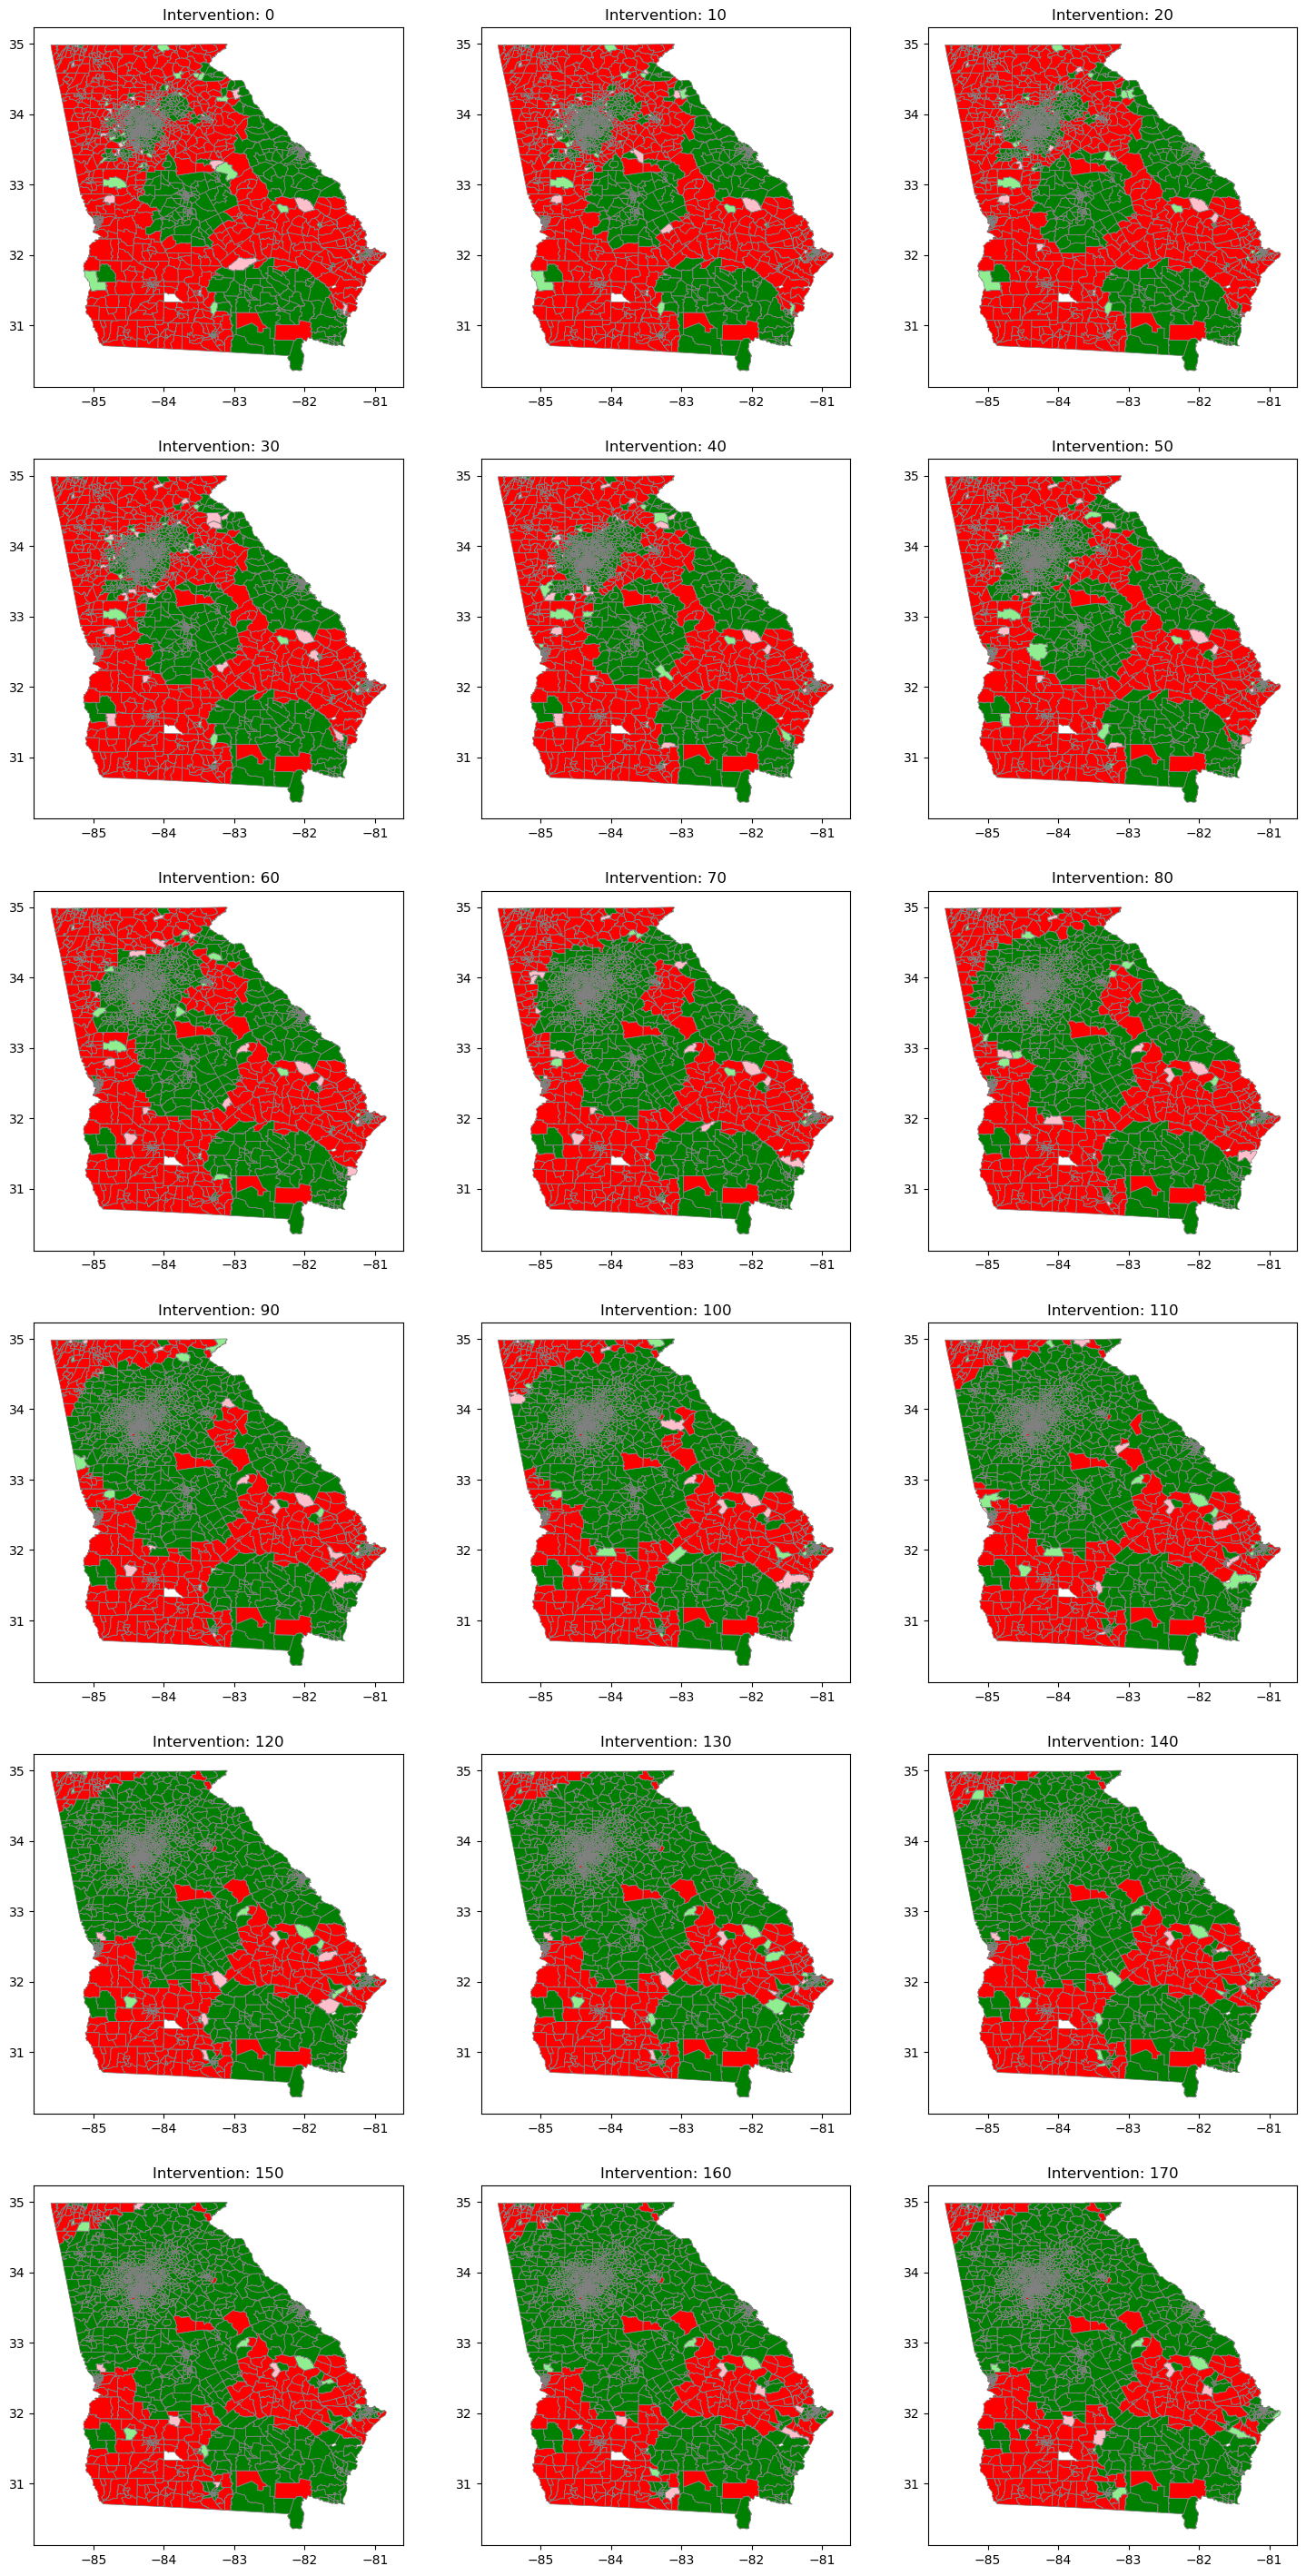

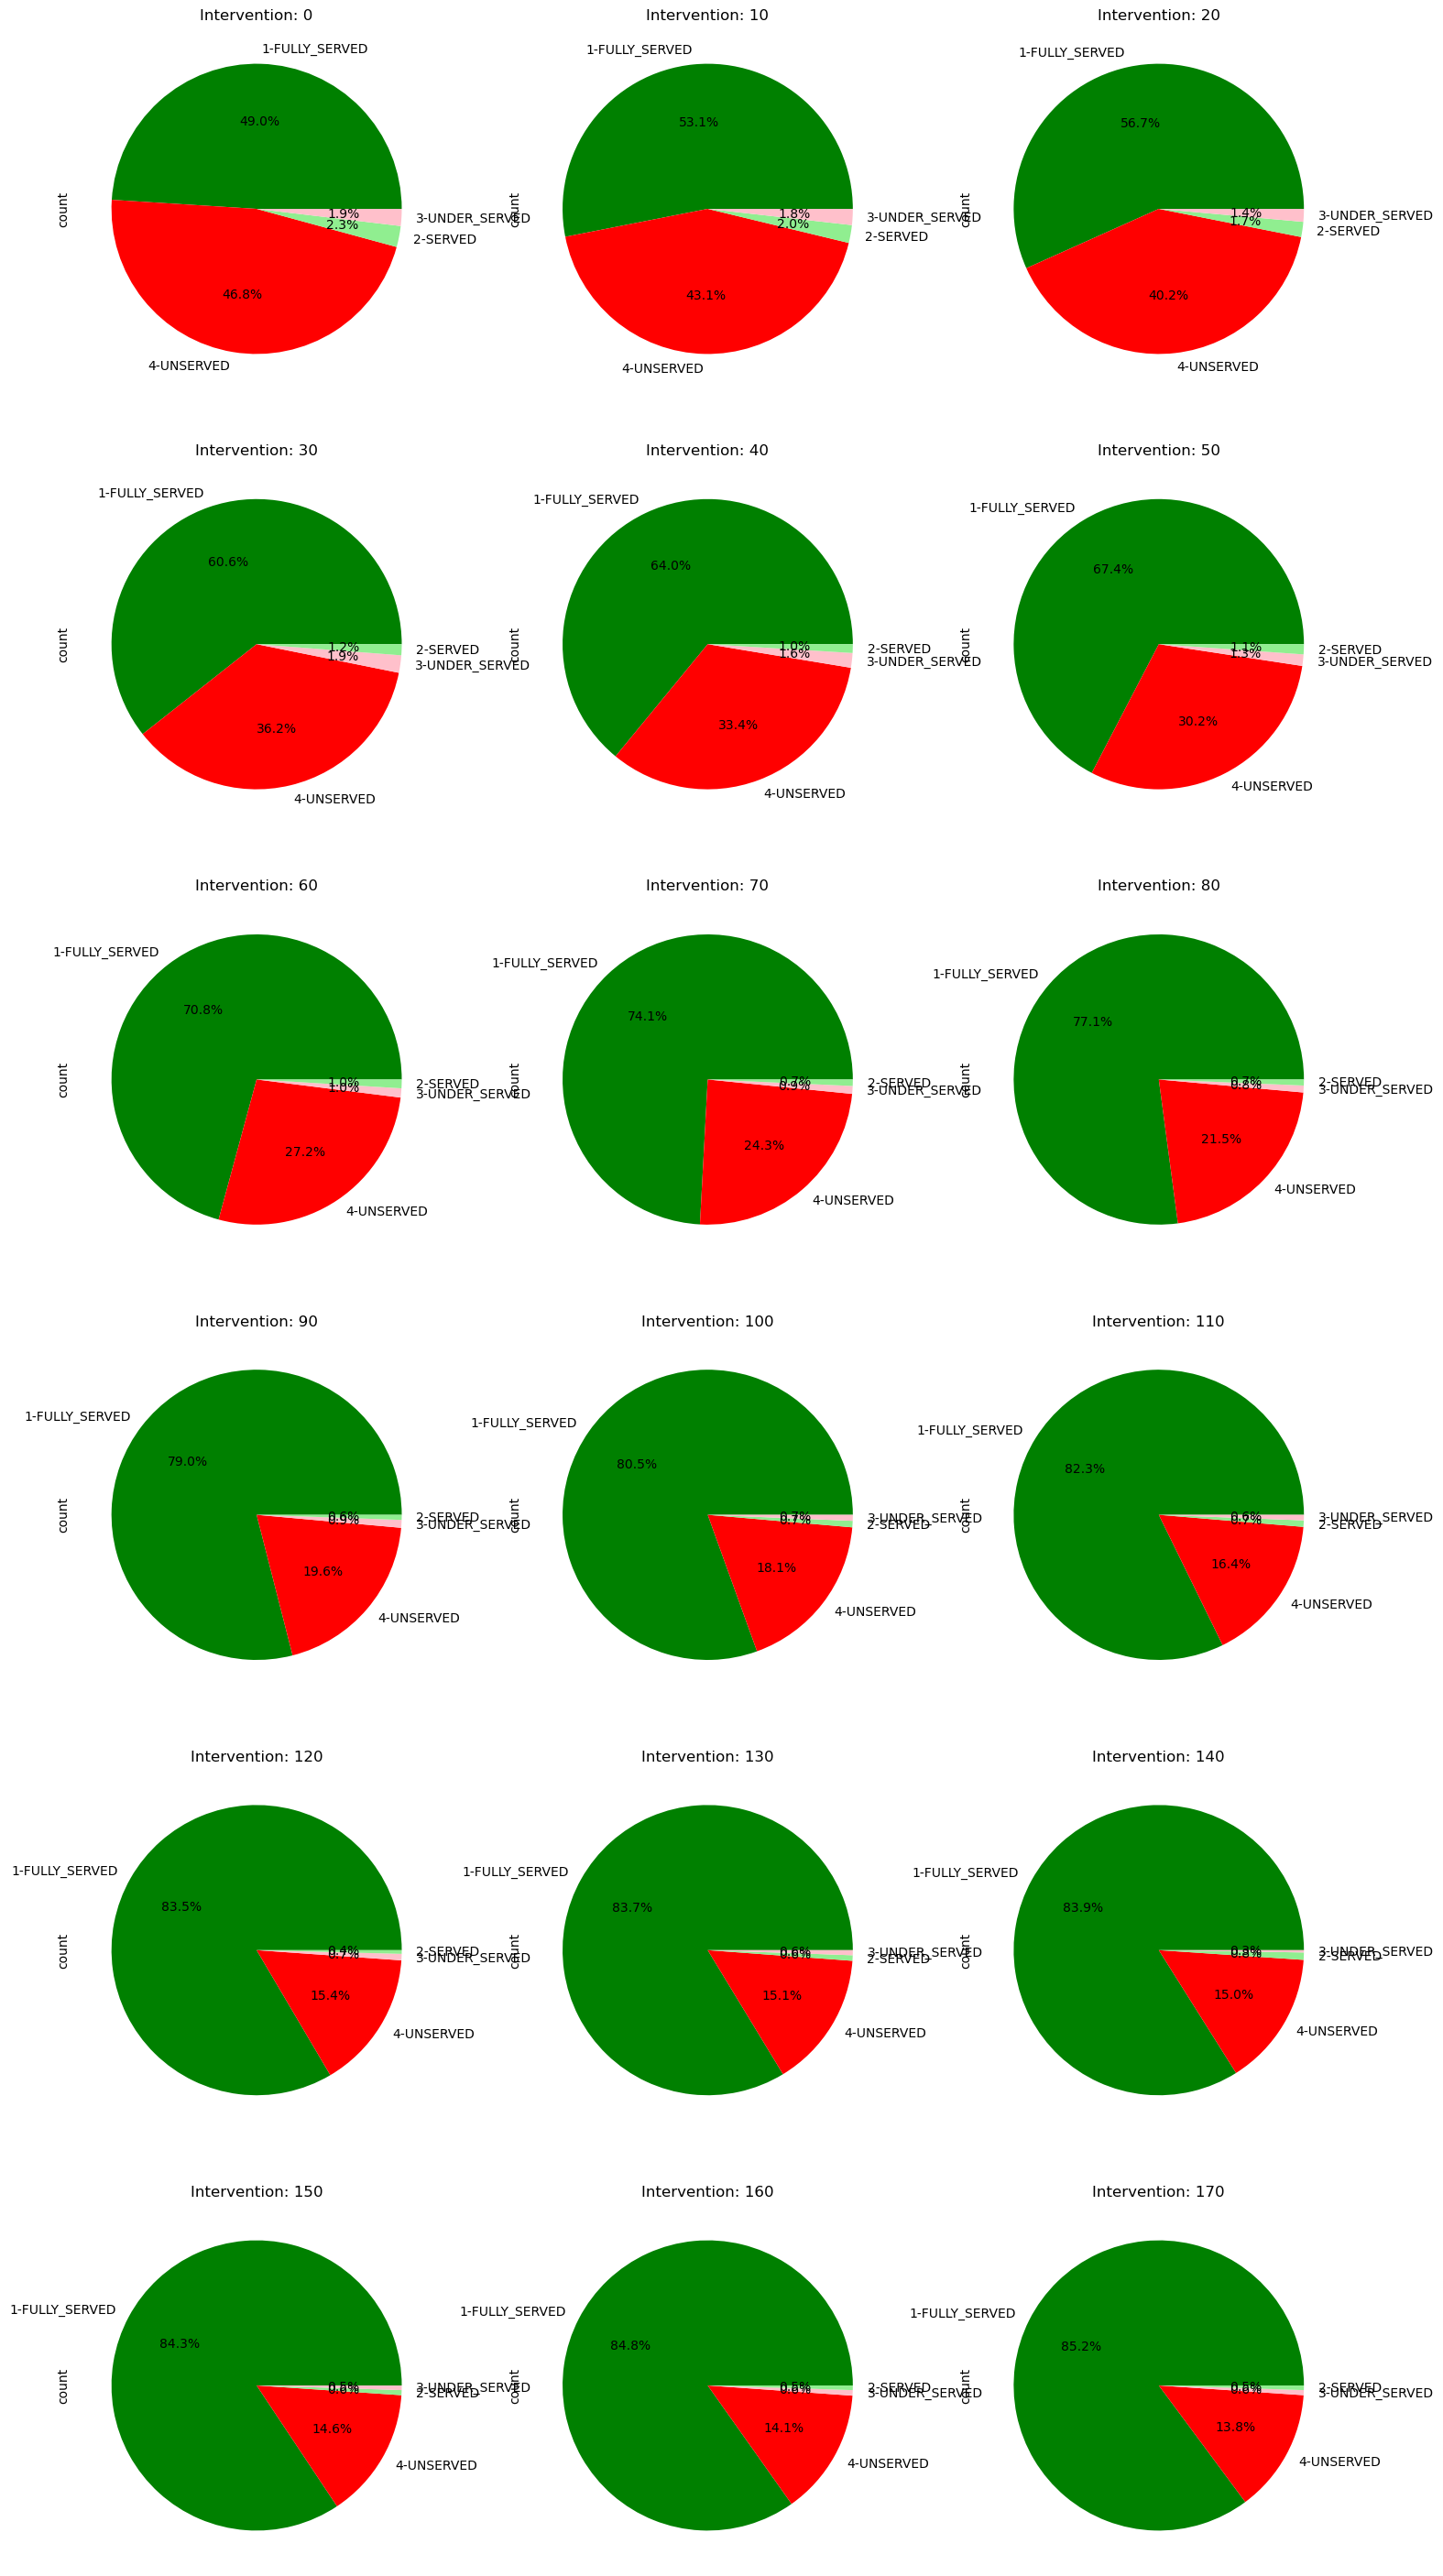

In [26]:
# Visualization
CATEGORY_CMAP = {
    '1-FULLY_SERVED': 'green',
    '2-SERVED': 'lightgreen',
    '3-UNDER_SERVED': 'pink',
    '4-UNSERVED': 'red',
}

def plot_measure():
    measureDF = pd.read_csv("result/model_measure.csv", dtype={"GEOID": str})
    gdf = gpd.read_file("data/tract_1318.json")
    mergedDF = gdf.merge(measureDF, on="GEOID")
    visualize_measure(mergedDF)
    
def visualize_measure(DF):
    interventionList = DF['INTERVENTION'].unique()
    if len(interventionList) % 3 == 0:
        nrow, ncol = len(interventionList) // 3, 3
    else:
        nrow, ncol = len(interventionList) // 3 + 1, 3
    fig1, ax1 = plt.subplots(nrow, ncol, figsize=(6 * ncol, 6 * nrow))
    fig2, ax2 = plt.subplots(nrow, ncol, figsize=(6 * ncol, 6 * nrow))
    for i, intervention in enumerate(tqdm(interventionList)):
        currDF = DF[DF['INTERVENTION'] == intervention]
        if currDF.empty:
            print(f"Intervention: {intervention} has no data")
        else:
            currDF.plot(ax=ax1[i // ncol, i % ncol], legend=False, color=currDF['COLOR'])
            currDF.boundary.plot(ax=ax1[i // ncol, i % ncol], color='grey', linewidth=0.5)
            ax1[i // ncol, i % ncol].set_title(f"Intervention: {intervention}")
            
            categoryCount = currDF['CATEGORY'].value_counts()
            categoryCount.plot(kind='pie', ax=ax2[i // ncol, i % ncol], legend=False, autopct='%1.1f%%', colors=[CATEGORY_CMAP[category] for category in categoryCount.index])
            ax2[i // ncol, i % ncol].set_title(f"Intervention: {intervention}")
    fig1.savefig(f"analysis/intervention_analysis_map.png")
    fig2.savefig(f"analysis/intervention_analysis_pie.png")
    
plot_measure()

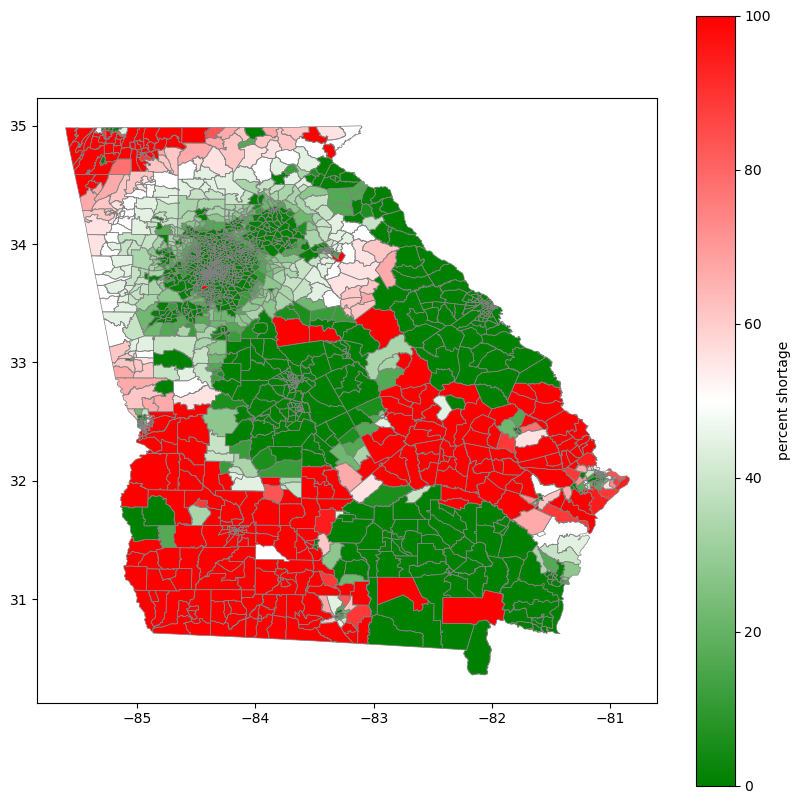

In [27]:
BAR_CMAP = mcolors.LinearSegmentedColormap.from_list('Red', ["green", "white", "red"], N=256)
def plot_shortage():
    shortageDF = pd.read_csv("result/model_shortage.csv", dtype={"GEOID": str})
    gdf = gpd.read_file("data/tract_1318.json")
    mergedDF = gdf.merge(shortageDF, on="GEOID")
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    mergedDF.plot(
                column='PERCENT_SHORTAGE',
                ax=ax,
                legend=True,
                cmap=BAR_CMAP,
                legend_kwds={
                    "label": "percent shortage",
                    "orientation": "vertical",
                    "location": "right",
                },
            )
    mergedDF.boundary.plot(ax=ax, color='grey', linewidth=0.5)
    fig.savefig(f"analysis/shortage_analysis.png")
plot_shortage()

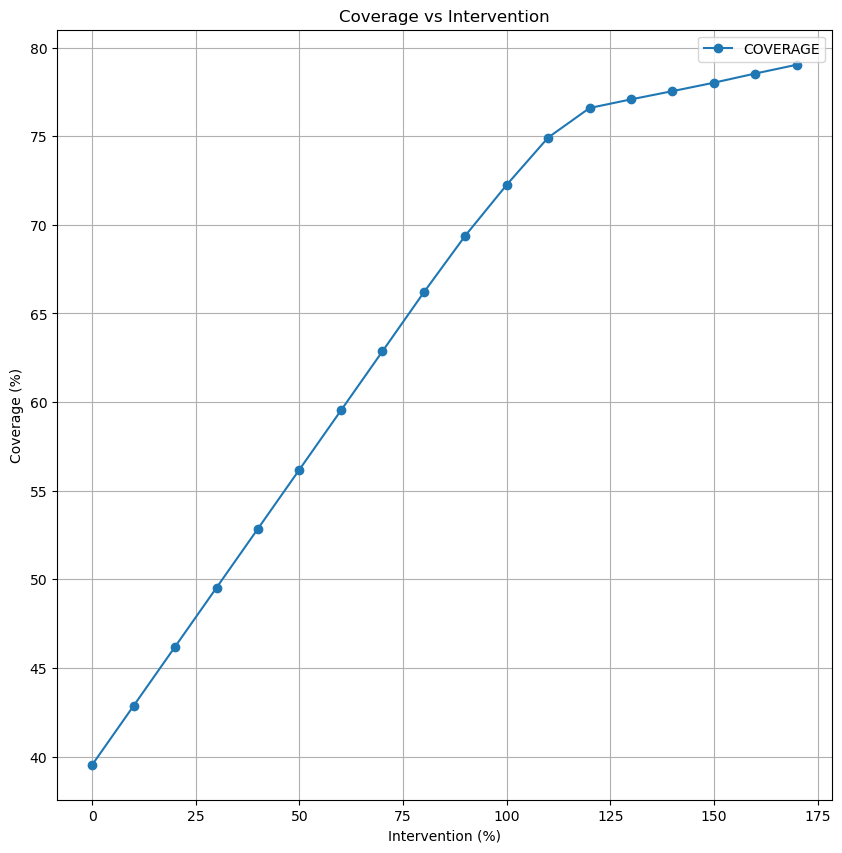

In [28]:
def plot_coverage():
    coverageDF = pd.read_csv("result/model_coverage.csv")
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    coverageDF.plot(
        x='INTERVENTION',
        y='COVERAGE',
        kind='line',
        ax=ax,
        marker='o'
    )
    ax.set_xlabel('Intervention (%)')
    ax.set_ylabel('Coverage (%)')
    ax.set_title('Coverage vs Intervention')
    plt.grid()
    plt.savefig(f"analysis/coverage_analysis.png")
plot_coverage()